## User Report for Refinement and Transfer Learning

This notebook provides a detailed analysis of data exploration and training results for an automatic refinement and transfer learning pipeline. It includes visualizations of key dataset features like amino acid distribution, sequence lengths, collision energy, and intensity values for train, validation, and test sets. Spectral angle distributions are calculated and saved before and after training, enabling comparison of model performance. Training results, including learning curves and performance metrics, are documented to highlight improvements through the training stages.

In [1]:
import os
import json
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
LOGGING_DIR = '/nfs/home/students/s.baier/mapra/dlomix/bmpc_scripts_sylvie/results_log/log_data/'

### Data exploration

In [3]:
def plot_json_data(results_log):
    def load_json(filename):
        with open(filename, 'r') as f:
            return json.load(f)

    def plot_amino_acid_distribution(datasets=['train', 'val', 'test']):
        fig, axes = plt.subplots(len(datasets), 1, figsize=(18, 5 * len(datasets)), sharey=True)
        for i, dataset in enumerate(datasets):
            file_path = os.path.join(results_log, f'amino_acid_distribution_{dataset}.json')
            if os.path.exists(file_path):
                data = load_json(file_path)
                alphabet_keys = data['alphabet']
                aa_counts = data['counts']

                # Filter out amino acids with a count of 0
                filtered_keys_counts = [(k, c) for k, c in zip(alphabet_keys, aa_counts) if c > 0]
                filtered_keys = [k for k, c in filtered_keys_counts]
                filtered_counts = [c for k, c in filtered_keys_counts]

                axes[i].bar(filtered_keys, filtered_counts, edgecolor='black')
                axes[i].set_title(f'{dataset.capitalize()} Set')
                axes[i].set_xlabel('Amino Acid')
                axes[i].set_ylabel('Frequency')
                axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

        plt.tight_layout()
        plt.show()

    def plot_distribution(feature, xlabel='', ylabel='Frequency', is_sequence=False, transform_func=None):
        datasets = ['train', 'val', 'test']
        fig, axes = plt.subplots(1, len(datasets), figsize=(18, 6), sharey=True)
        
        for i, dataset in enumerate(datasets):
            file_path = os.path.join(results_log, f'{feature}_distribution_{dataset}.json')
            if os.path.exists(file_path):
                data = load_json(file_path)
                feature_data = data['hist']
                bin_edges = data['bin_edges']
                axes[i].hist(bin_edges[:-1], bins=bin_edges, weights=feature_data, edgecolor='black')
                axes[i].set_title(f'{dataset.capitalize()} Set')
                axes[i].set_xlabel(xlabel)
                if i == 0:
                    axes[i].set_ylabel(ylabel)

        fig.suptitle(f'{xlabel.title()} Distribution')
        plt.tight_layout()
        plt.show()

    plot_amino_acid_distribution()
    plot_distribution('collision_energy_aligned_normed', xlabel='Collision Energy')
    # plot_distribution('intensities_raw', xlabel='Intensity')
    plot_distribution('sequence', xlabel='Sequence Length')
    plot_distribution('precursor_charge_onehot', xlabel='Precursor Charge')


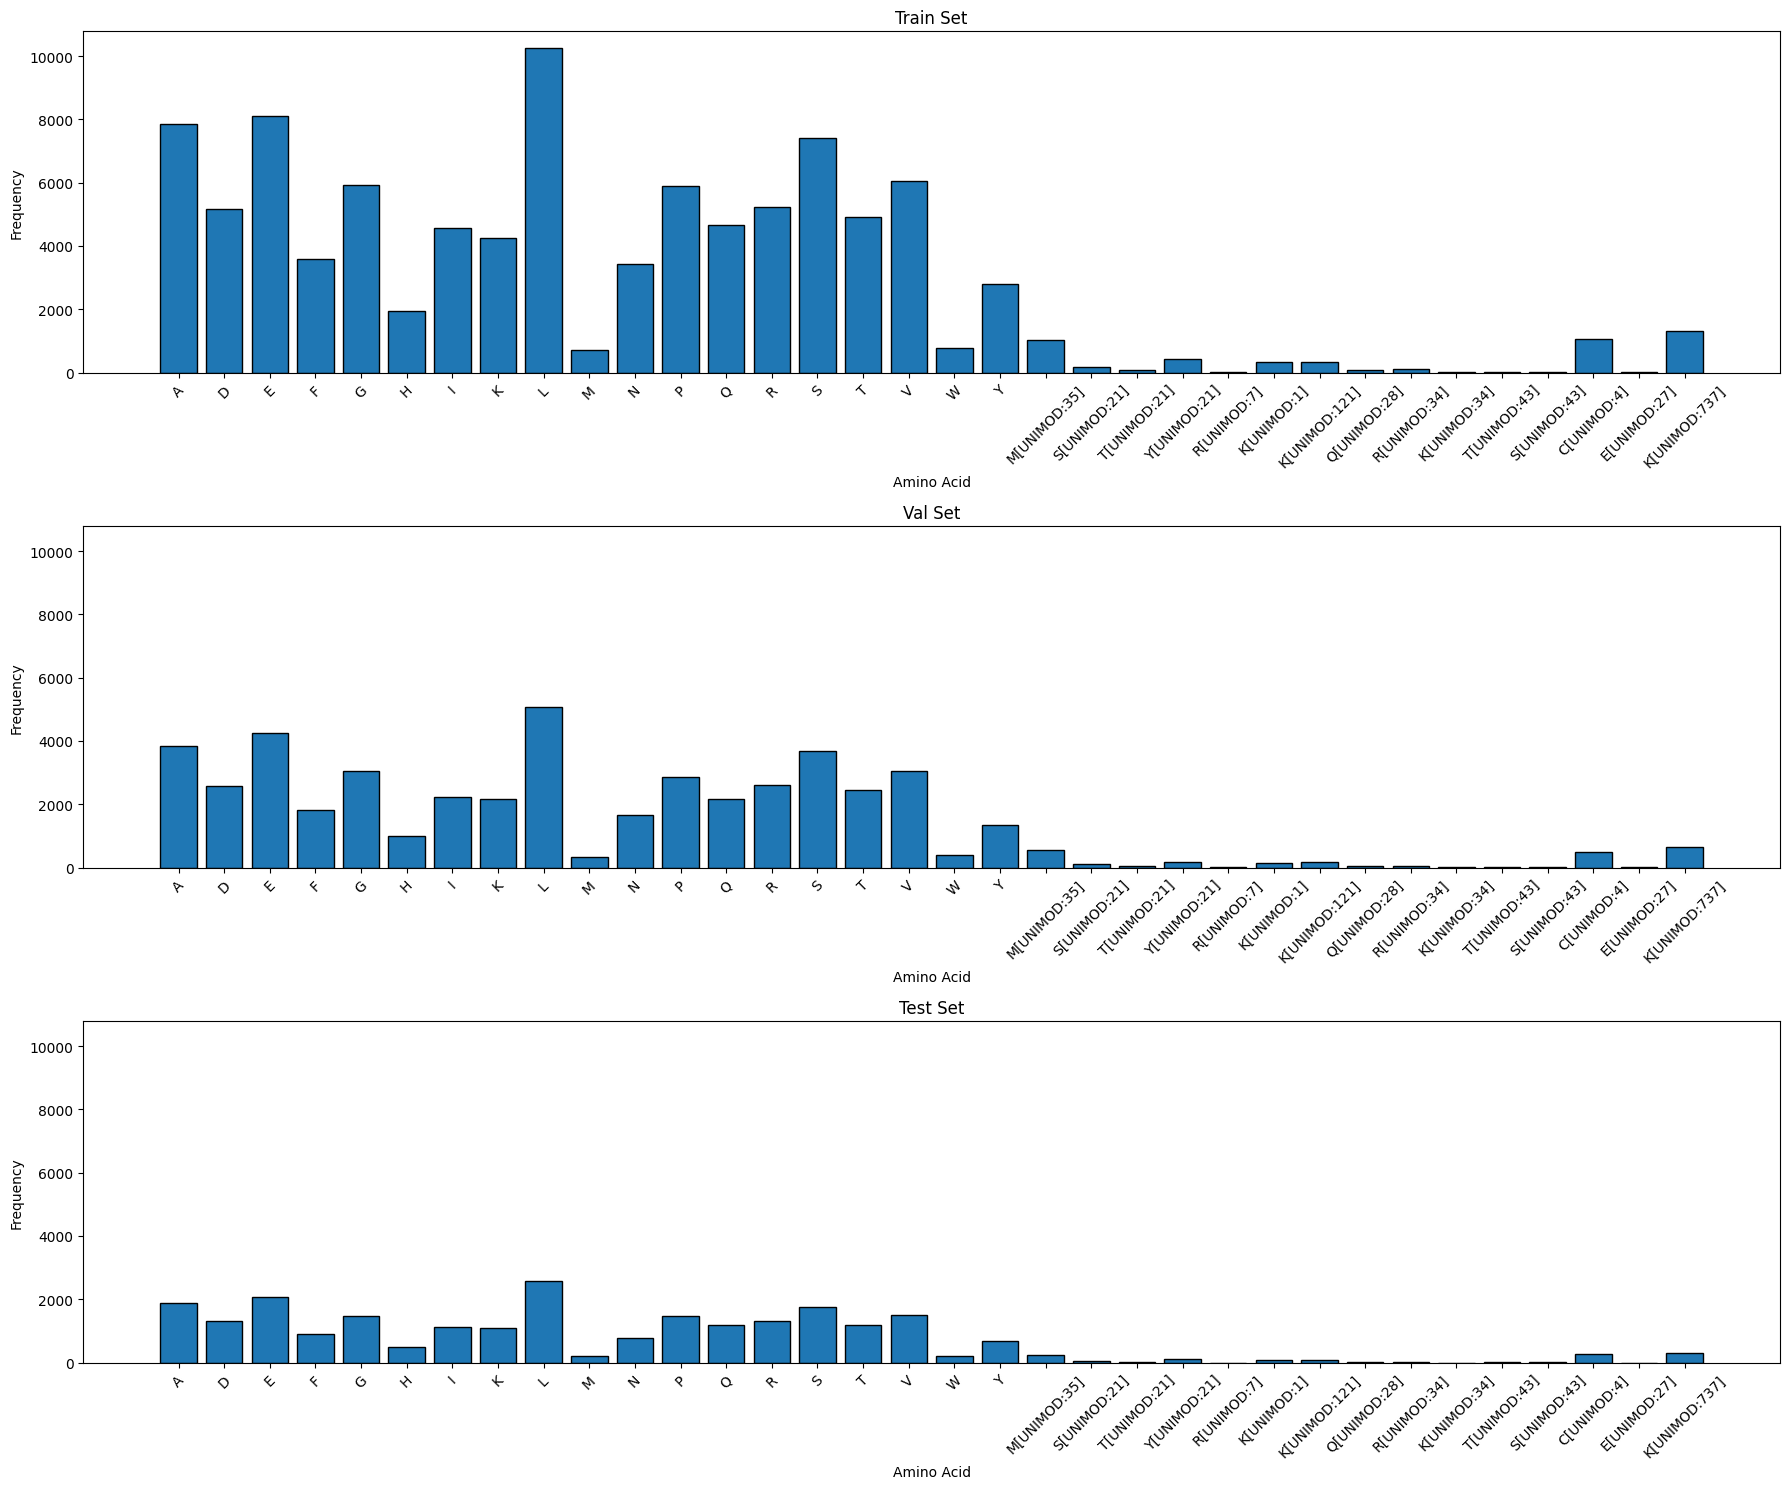

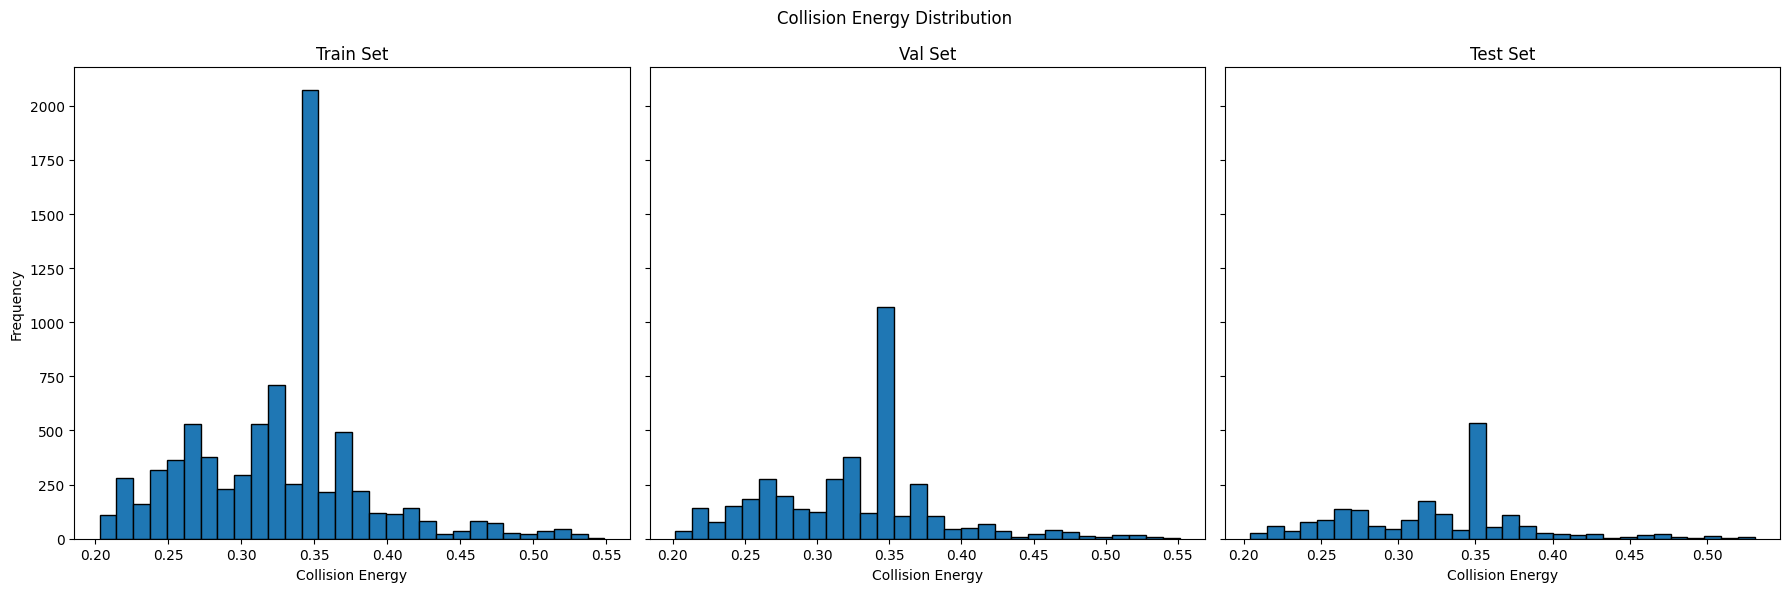

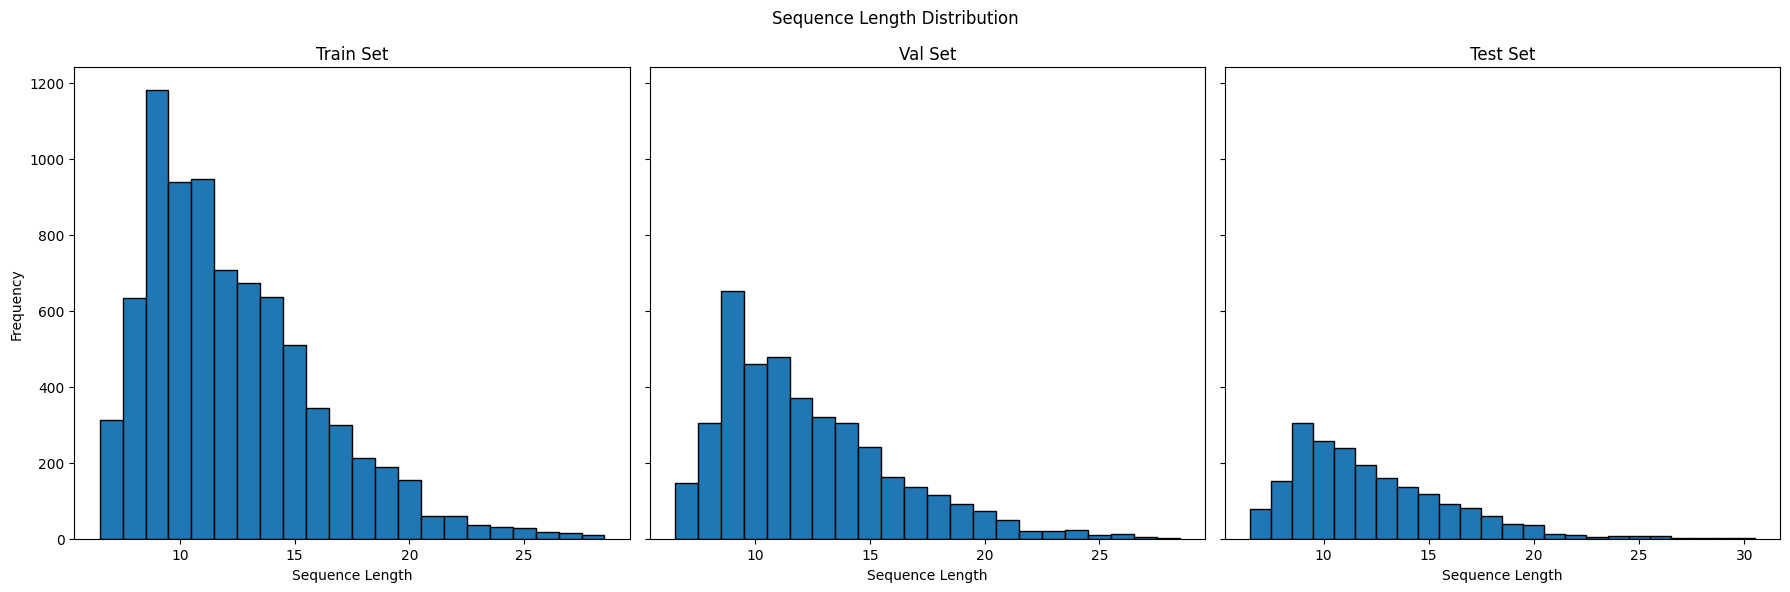

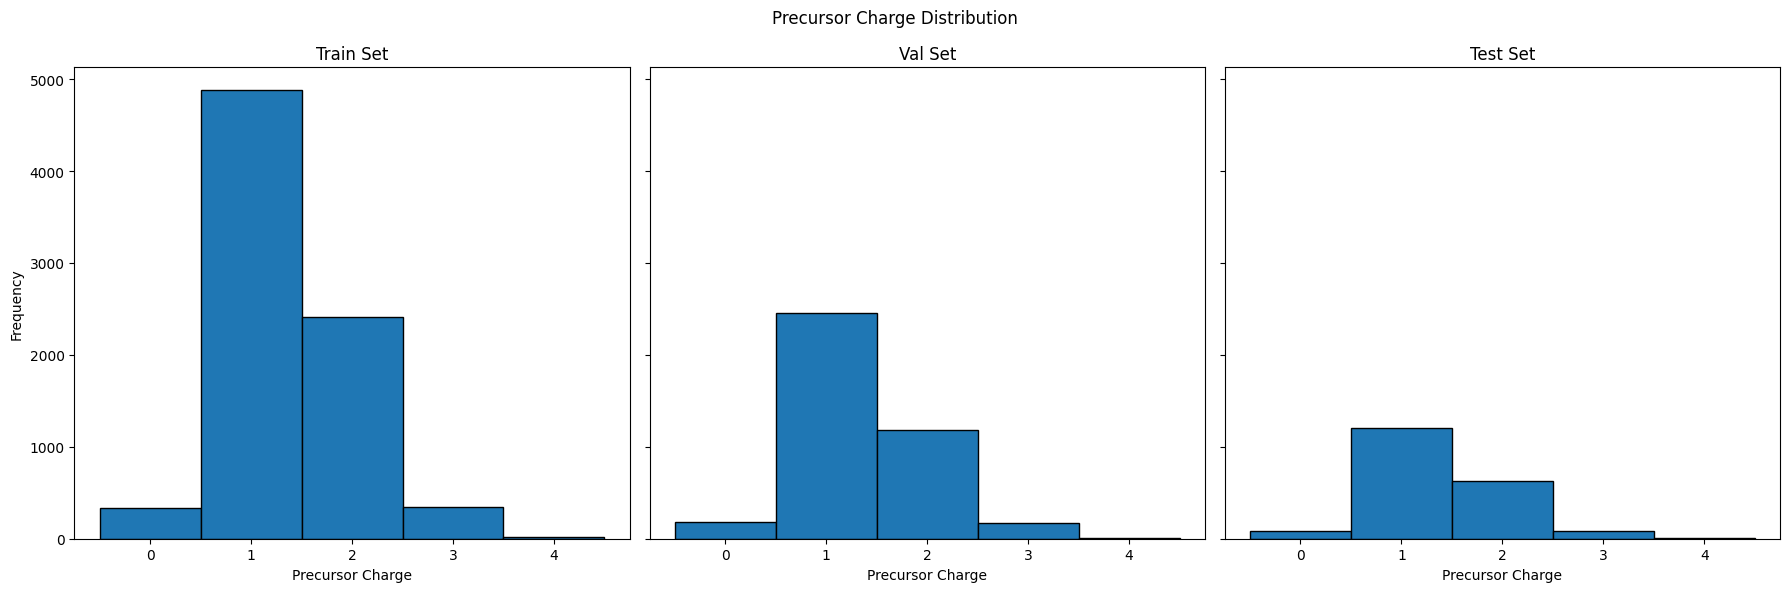

In [4]:
# Call the function to plot the data
plot_json_data(LOGGING_DIR)

### Training results

##### Spectral Angle Distribution

In [5]:
def plot_spectral_angle_distributions(results_log, datasets=['train', 'val', 'test']):
    """
    Reads the spectral angle distributions from JSON files and plots them before and after training.

    Args:
        results_log: Directory where the JSON files are saved.
        datasets: A list of strings indicating which datasets to plot ('train', 'val', 'test').

    Returns:
        None (plots the distributions)
    """
    def load_json(filename):
        with open(filename, 'r') as f:
            return json.load(f)
    
    fig_before, axes_before = plt.subplots(1, len(datasets), figsize=(18, 6), sharey=True)
    fig_after, axes_after = plt.subplots(1, len(datasets), figsize=(18, 6), sharey=True)
    
    for ax_before, ax_after, dataset in zip(axes_before, axes_after, datasets):
        filename = os.path.join(results_log, f'spectral_angle_distribution_{dataset}.json')
        if os.path.exists(filename):
            data = load_json(filename)
            spectral_angles_before = data['before']['spectral_angles']
            avg_sa_before = data['before']['average_spectral_angle']
            spectral_angles_after = data['after']['spectral_angles']
            avg_sa_after = data['after']['average_spectral_angle']

            # Plot before training
            ax_before.hist(spectral_angles_before, bins=30, alpha=0.75, edgecolor='black')
            ax_before.axvline(avg_sa_before, color='r', linestyle='dashed', linewidth=1)
            ax_before.text(ax_before.get_xlim()[1] * 0.3, ax_before.get_ylim()[1] * 0.9, f'Avg. SA = {avg_sa_before:.2f}', color='r')
            ax_before.set_title(f'{dataset.capitalize()} Set Before Training')
            ax_before.set_xlabel('Spectral Angle')
            if dataset == datasets[0]:
                ax_before.set_ylabel('Frequency')

            # Plot after training
            ax_after.hist(spectral_angles_after, bins=30, alpha=0.75, edgecolor='black')
            ax_after.axvline(avg_sa_after, color='r', linestyle='dashed', linewidth=1)
            ax_after.text(ax_after.get_xlim()[1] * 0.3, ax_after.get_ylim()[1] * 0.9, f'Avg. SA = {avg_sa_after:.2f}', color='r')
            ax_after.set_title(f'{dataset.capitalize()} Set After Training')
            ax_after.set_xlabel('Spectral Angle')
            if dataset == datasets[0]:
                ax_after.set_ylabel('Frequency')
        else:
            print(f"No data found for {dataset} set.")

    plt.tight_layout()
    plt.show()


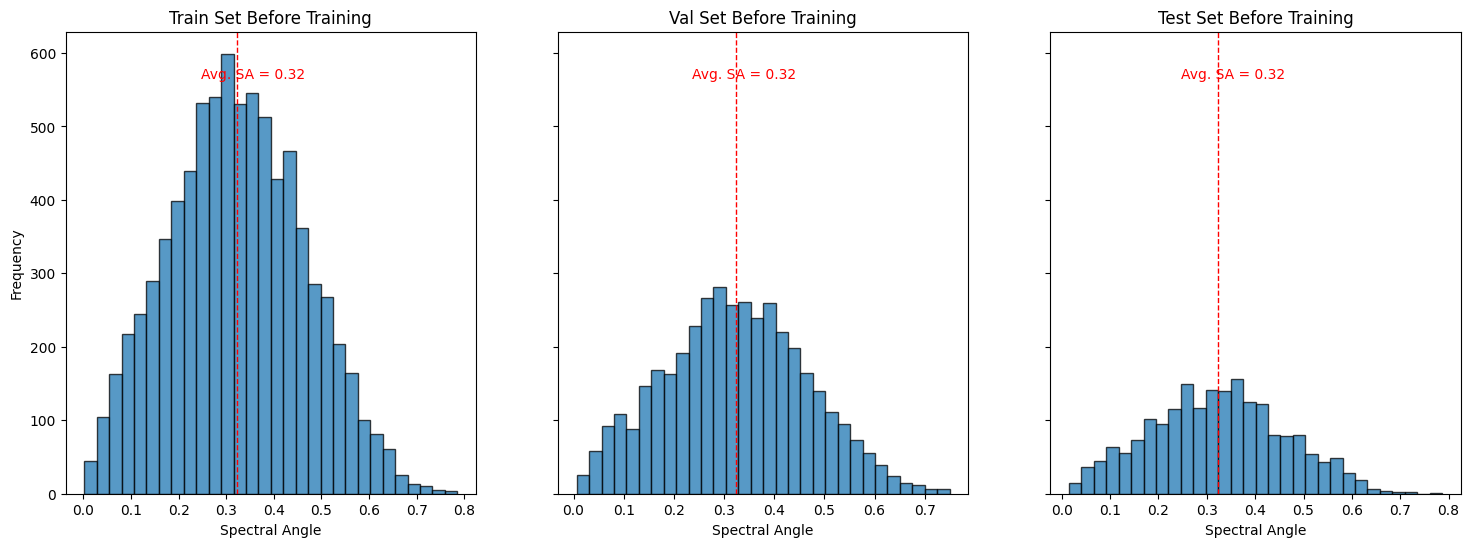

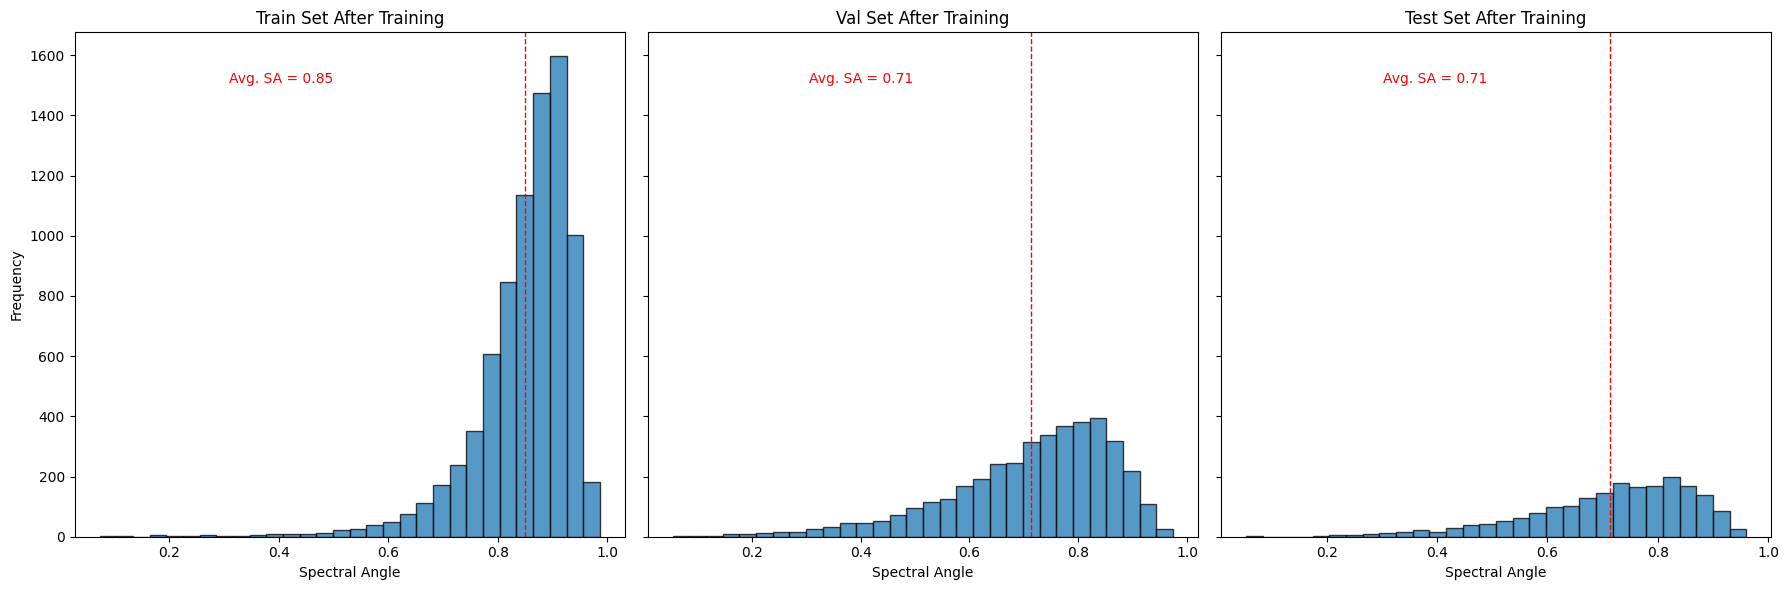

In [6]:
plot_spectral_angle_distributions(LOGGING_DIR)

The spectral angle distribution is computed using the first 1000 batches for each dataset type (training, validation, and test) to provide a representative overview. Calculating the distribution across the entire dataset would result in excessive runtime; therefore, using 1000 batches serves as a practical and efficient approximation.

#### Training process evaluation

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_data(data):
    """
    Plots specified columns in the provided DataFrame using seaborn, indicating the start of new phases.
    """
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    phase_transitions = data['phase'].diff().ne(0).cumsum() - 1
    colors = ['blue', 'green', 'brown']
    
    # Plot Loss and Validation Loss with new colors
    sns.lineplot(ax=axes[0, 0], data=data, x='batch', y='loss', color='#1f77b4')  # Deep Blue for Training
    sns.lineplot(ax=axes[0, 0], data=data, x='batch', y='val_loss', color='#b41f4c')  # Soft Red for Validation
    for i in range(phase_transitions.nunique()):
        pt_indices = data.index[phase_transitions == i].tolist()
        if pt_indices:
            pt = pt_indices[0]
            axes[0, 0].axvline(x=data['batch'].iloc[pt], color=colors[i % len(colors)], linestyle='--', alpha=0.5)
    axes[0, 0].set_title('Loss and Validation Loss')
    axes[0, 0].set_xlabel('Batches')
    axes[0, 0].set_ylabel('Loss')

    # Plot Masked Pearson Correlation Distance and Validation Masked Pearson Correlation Distance
    sns.lineplot(ax=axes[0, 1], data=data, x='batch', y='masked_pearson_correlation_distance', color='#1f77b4')
    sns.lineplot(ax=axes[0, 1], data=data, x='batch', y='val_masked_pearson_correlation_distance', color='#b41f4c')
    for i in range(phase_transitions.nunique()):
        pt_indices = data.index[phase_transitions == i].tolist()
        if pt_indices:
            pt = pt_indices[0]
            axes[0, 1].axvline(x=data['batch'].iloc[pt], color=colors[i % len(colors)], linestyle='--', alpha=0.5)
    axes[0, 1].set_title('Masked Pearson Correlation Distance and Validation')
    axes[0, 1].set_xlabel('Batches')
    axes[0, 1].set_ylabel('Masked Pearson Correlation Distance')

    # Plot Learning Rate 
    sns.lineplot(ax=axes[1, 0], data=data, x='batch', y='learning_rate', color='#4d4d4d') 
    for i in range(phase_transitions.nunique()):
        pt_indices = data.index[phase_transitions == i].tolist()
        if pt_indices:
            pt = pt_indices[0]
            axes[1, 0].axvline(x=data['batch'].iloc[pt], color=colors[i % len(colors)], linestyle='--', alpha=0.5)
    axes[1, 0].set_title('Learning Rate')
    axes[1, 0].set_xlabel('Batches')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')

    # Remove the unused fourth subplot
    fig.delaxes(axes[1, 1])

    # Create a custom legend
    handles = [
        plt.Line2D([0], [0], color='#1f77b4', lw=2, label='Training'),
        plt.Line2D([0], [0], color='#b41f4c', lw=2, label='Validation')
    ]
    # Add phase transitions to the legend
    for i in range(phase_transitions.nunique()):
        handles.append(plt.Line2D([0], [0], color=colors[i % len(colors)], linestyle='--', lw=2, label=f'Phase {i+1}'))

    # Add overall legend
    fig.legend(handles=handles, loc='upper center', ncol=3)

    plt.show()


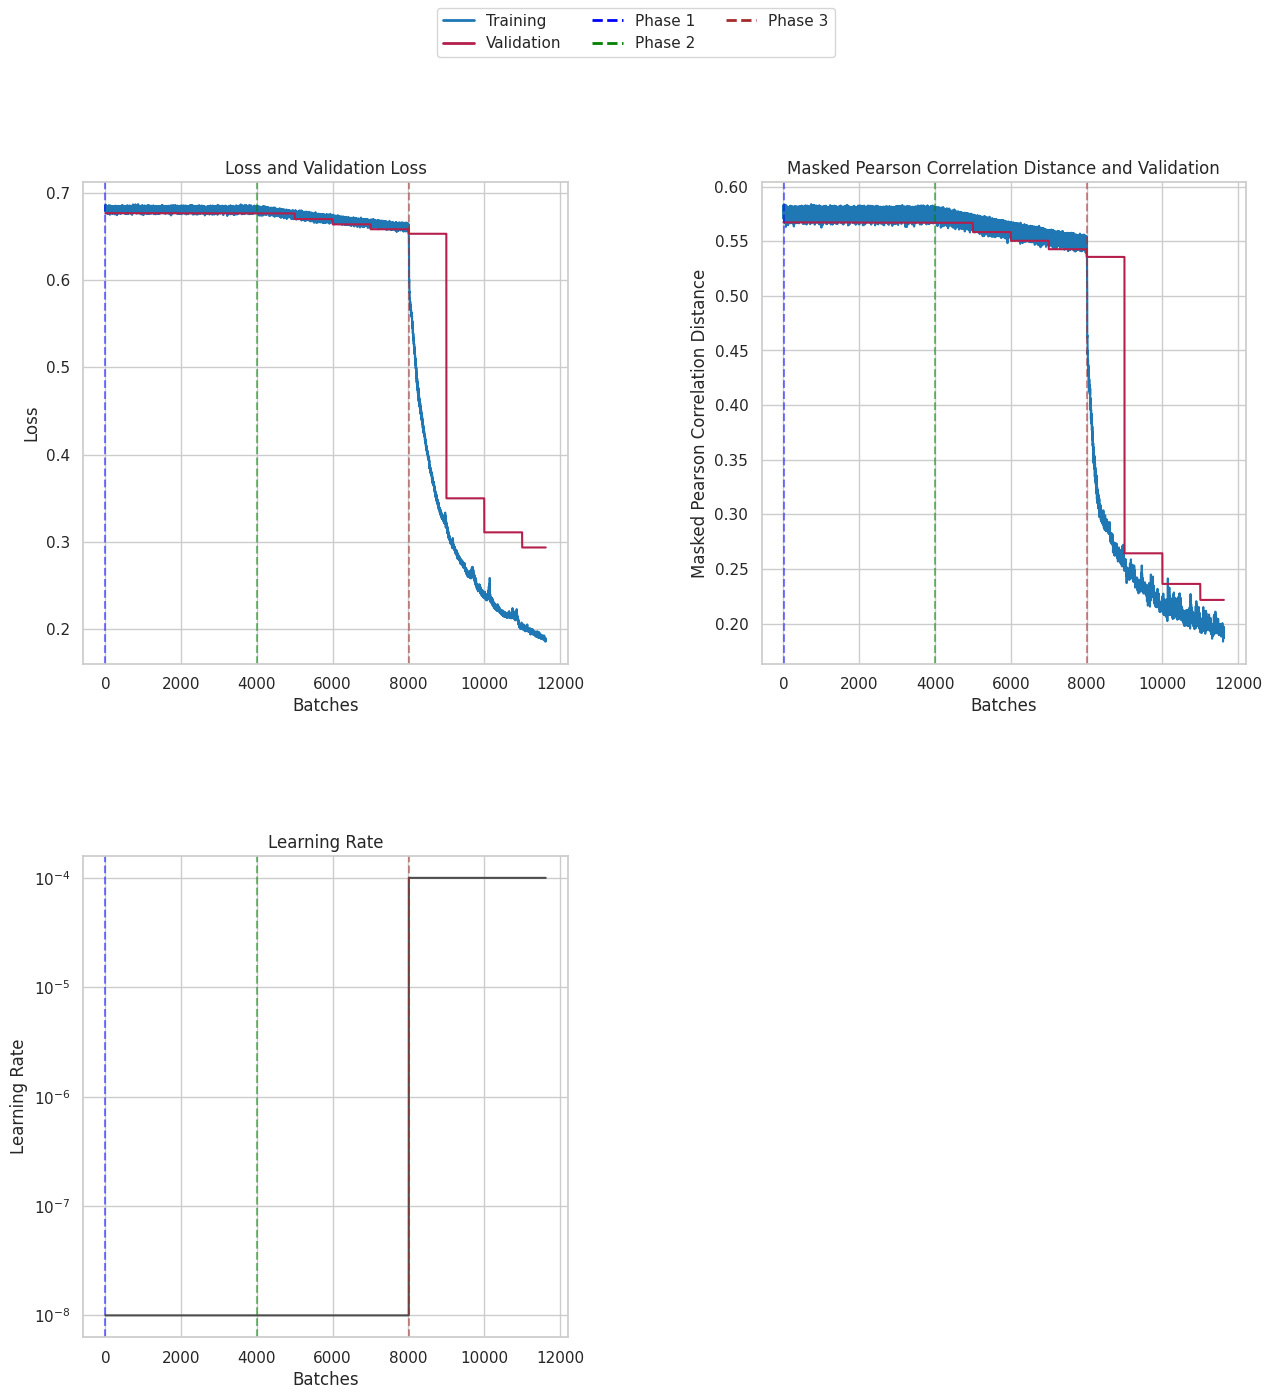

In [8]:
logged_training_results = pd.read_csv(f'{LOGGING_DIR}training_log.csv')
plot_data(logged_training_results)

In [9]:
if logged_training_results.iloc[-1]['val_loss'] > 0.2:
    val_loss_value = logged_training_results.iloc[-1]['val_loss']
    print(f"The model didn't learn enough about the data, leading to a validation loss higher than 0.2. The current validation loss is {val_loss_value:.6f}.")

The model didn't learn enough about the data, leading to a validation loss higher than 0.2. The current validation loss is 0.293613.


Freezing per phase

In [10]:
logged_freezing = pd.read_csv(f'{LOGGING_DIR}freeze_log.csv', header=None, names=["freezing", "status"], skip_blank_lines=False)
logged_freezing['Phase'] = logged_freezing['freezing'].isna().cumsum() + 1
logged_freezing = logged_freezing.dropna().reset_index(drop=True)
logged_freezing['Phase'] = logged_freezing['Phase'].apply(lambda x: f"Phase {x}")
logged_freezing['status'] = logged_freezing['status'].astype(int)
logged_freezing

,freezing,status,Phase
0,freeze_old_embedding_weights,0,Phase 1
1,freeze_old_regressor_weights,0,Phase 1
2,freeze_inner_layers,1,Phase 1
3,freeze_embedding_layer,0,Phase 1
4,freeze_regressor_layer,1,Phase 1
5,freeze_old_embedding_weights,0,Phase 2
6,freeze_old_regressor_weights,0,Phase 2
7,freeze_inner_layers,0,Phase 2
8,freeze_embedding_layer,0,Phase 2
9,freeze_regressor_layer,0,Phase 2
